In [28]:
import pandas as pd
import numpy as np

from sklearn.svm import SVC
import shap

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from os.path import join 
from scipy.io import loadmat 

import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import parallel_backend
import xgboost 
from xgboost.sklearn import XGBModel
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, plot_roc_curve

## Creating DataFrame for Classification 

In [5]:
main_path = '/Users/nicobruno/Downloads/mind_blanking-master/Results/'
schaefer_res = [100] 
gs_types = ['Normal']
lags = [0]
labs = ['', 'Rest', 'MB', 'Sens', 'SDep', 'SInd']
subs = [f'sub_{i}' for i in range(1,37)]
for res in schaefer_res: 
    for gs_type in gs_types: 
        for lag in lags: 
            df_pat = loadmat(join(main_path,f'parcel_{res}/{gs_type}/lag_{lag}/Patterns.mat'))
            features = df_pat['Patterns'].T 
            subjects = df_pat['Subject_Pointer'][0]
            subjects = [subs[int(subjects[i])] for i in range(len(subjects))]
            labels = df_pat['Report_Pointer'][0]
            labels = [labs[int(labels[i])] for i in range(len(labels))]
            df = pd.DataFrame(features)
            df['subject'] = subjects
            df['labels'] = labels
df = df[df['labels']!='Rest']

# converting connectivity measure column labels to strings to make life easier 
X = [f'{i}' for i in range(int((res*(res-1))/2))]
df.columns = X+['subject']+['labels']

# Adding new column to make MB vs others labels 
df['bin_labels'] = df['labels']
df.loc[(df['bin_labels']!='SInd'), 'bin_labels'] = 'others'

df_MWSens = df[(df['labels']=='SInd')|(df['labels']=='Sens')]
df_MWSDep = df[(df['labels']=='SInd')|(df['labels']=='SDep')]
df_MWMB = df[(df['labels']=='SInd')|(df['labels']=='MB')]

df

,0,1,2,3,4,5,6,7,8,9,...,4943,4944,4945,4946,4947,4948,4949,subject,labels,bin_labels
10,-0.986328,-0.724121,0.828613,-0.999512,0.980469,0.701172,-0.941406,0.872559,0.448975,0.951660,...,-0.924805,-0.328369,-0.999023,0.749023,-0.318604,-0.766602,-0.497803,sub_1,SDep,others
11,-0.762695,-0.230591,0.805176,-0.887207,0.975098,0.653809,-0.992188,0.838379,0.352051,0.938477,...,-0.821289,-0.309570,-0.974609,0.618164,-0.379639,-0.817871,-0.191040,sub_1,SDep,others
12,-0.251709,0.263184,0.867188,-0.471191,0.972168,0.726562,-0.744141,0.833984,0.448486,0.939941,...,-0.759277,-0.200073,-0.955566,0.514160,-0.424316,-0.816406,0.051025,sub_1,SDep,others
13,0.378418,0.693848,0.929199,0.081543,0.953125,0.774414,-0.157715,0.854492,0.602051,0.971191,...,-0.754883,-0.013260,-0.966797,0.500000,-0.358154,-0.740234,0.143921,sub_1,SDep,others
14,0.864258,0.938965,0.984863,0.677734,0.955566,0.889648,0.607422,0.924316,0.843750,0.995605,...,-0.804199,0.296631,-0.998047,0.583008,-0.213867,-0.552246,0.151733,sub_1,SDep,others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26975,0.817383,0.917480,0.979004,0.775391,0.997559,0.962891,0.780273,0.998047,0.964844,1.000000,...,-0.186646,-0.291016,-0.462891,0.995117,0.999512,0.967285,0.287598,sub_36,Sens,others
26976,0.317627,0.451904,0.989258,0.322021,1.000000,0.990234,0.325928,1.000000,0.990723,1.000000,...,-0.187256,-0.147827,-0.514160,0.984863,0.988770,0.913086,0.118408,sub_36,Sens,others
26977,0.063538,0.096069,0.999512,0.140381,0.997070,0.999023,0.159058,0.995605,0.998047,1.000000,...,-0.109558,0.108032,-0.522949,0.961914,0.958984,0.797852,-0.768555,sub_36,Sens,others
26978,0.051727,-0.086670,0.990234,0.187744,0.990723,0.962402,0.244873,0.980957,0.944824,0.998047,...,0.000998,0.326660,-0.489014,0.913574,0.913086,0.538086,-0.961426,sub_36,Sens,others


# Cross-Validation MW vs ALL

In [6]:
R = 100 # Number of Regions 

order = np.array([37,38,39,40,41,42,43,44,45,46,47,48,49,
                  89,90,91,92,93,94,95,96,97,98,99,
                  
                  33,34,35,36,
                  80,81,82,83,84,85,86,87,88,
                  
                  9,10,11,12,13,14,
                  58,59,60,61,62,63,64,65,
                  
                  30,31,32,
                  78,79,
                  
                  23,24,25,26,27,28,29,
                  73,74,75,76,77,
                  
                  15,16,17,18,19,20,21,22,
                  66,67,68,69,70,71,72,
                  
                  0,1,2,3,4,5,6,7,8,
                  50,51,52,53,54,55,56,57
                 ])

order_dict = {}
for i in range(100):
    order_dict[i] = order[i]
    
idx = np.where(np.tril(np.ones((R,R)), k=-1))

k = np.array(list(order_dict.keys()))
v = np.array(list(order_dict.values()))
out = np.zeros_like(idx[0])
for key,val in zip(k,v):
    out[idx[0]==key] = val

DMN =  range(0,24)
Cont = range(24,37) 
SM =  range(37,51) 
Lm = range(51,57) 
VA = range(57,68) 
DA= range(68,84) 
Vis = range(84,100)

DMN_counter = 0 
Cont_counter = 0
SM_counter = 0 
Lm_counter = 0
VA_counter = 0
DA_counter = 0
Vis_counter = 0

cols_dict_replace = {}

for i, v in enumerate(out):    
    if v in DMN:
        cols_dict_replace[f'{i}'] = ('DMN',DMN_counter)
        DMN_counter+=1
    elif v in Cont:
        cols_dict_replace[f'{i}'] = ('Cont',Cont_counter)
        Cont_counter+=1
    elif v in SM:
        cols_dict_replace[f'{i}'] = ('SM',SM_counter)
        SM_counter+=1
    elif v in Lm:
        cols_dict_replace[f'{i}'] = ('Lm',Lm_counter)
        Lm_counter+=1
    elif v in VA:
        cols_dict_replace[f'{i}'] = ('VA',VA_counter)
        VA_counter+=1
    elif v in DA:
        cols_dict_replace[f'{i}'] = ('DA',DA_counter)
        DA_counter+=1
    elif v in Vis:
        cols_dict_replace[f'{i}'] = ('Vis',Vis_counter)
        Vis_counter+=1
    else:
        print(i)    
        
df.rename(columns = cols_dict_replace, inplace = True)


In [7]:
X = df.drop(columns =['subject', 'labels', 'bin_labels'])
X.columns =pd.MultiIndex.from_tuples(X.columns, names=["Network", "Combination"])
y = df['bin_labels'].values

labels = ['DMN', 'Cont', 'SM', 'Lm', 'VA', 'DA', 'Vis']

average_X = pd.DataFrame()
for i in labels:
    average_X[i] = np.mean(X[i], axis = 1)


# Model with all patterns

In [8]:
le = preprocessing.LabelEncoder()
y_trans = le.fit_transform(y)

model = RandomForestClassifier(bootstrap=True, 
random_state=42,  warm_start=False)

pipeline = Pipeline(steps = [('RF', model)])


cv = StratifiedKFold(n_splits = 5, shuffle =  True,random_state=42)
scores = cross_val_score(pipeline,X, y_trans, cv = cv , scoring = 'roc_auc')

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. 

In [9]:
scores

array([0.99630802, 0.99655433, 0.99678959, 0.99531565, 0.99721721])

In [10]:
model.fit(X, y)
explainer = shap.TreeExplainer(model)
explainer.feature_names = labels
shap_values = explainer.shap_values(X)

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.


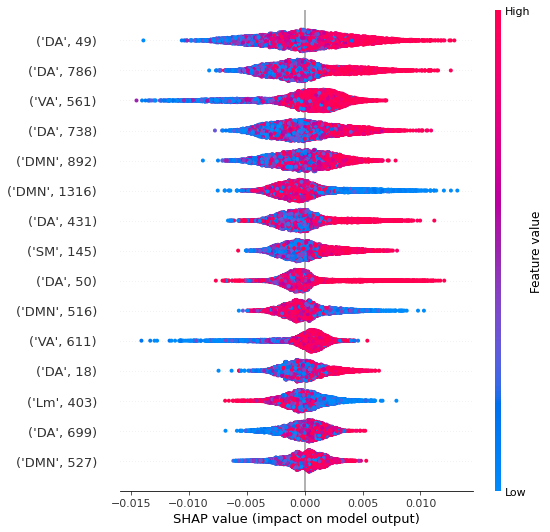

<Figure size 432x288 with 0 Axes>

In [18]:
shap.summary_plot(shap_values[1], X,  max_display = 15)
plt.savefig("shap_MWvsALL_beeswarm.pdf") 

In [19]:
expected_value = explainer.expected_value
shap.decision_plot(expected_value[1], shap_values[1],feature_names=list(X.columns), ignore_warnings = True)

RuntimeError: Plotting 8860 observations may be slow. Consider subsampling or set ignore_warnings=True to ignore this message.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0],X)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


# MW vs Distraction (Sdepn)

In [20]:
R = 100 # Number of Regions 

order = np.array([37,38,39,40,41,42,43,44,45,46,47,48,49,
                  89,90,91,92,93,94,95,96,97,98,99,
                  
                  33,34,35,36,
                  80,81,82,83,84,85,86,87,88,
                  
                  9,10,11,12,13,14,
                  58,59,60,61,62,63,64,65,
                  
                  30,31,32,
                  78,79,
                  
                  23,24,25,26,27,28,29,
                  73,74,75,76,77,
                  
                  15,16,17,18,19,20,21,22,
                  66,67,68,69,70,71,72,
                  
                  0,1,2,3,4,5,6,7,8,
                  50,51,52,53,54,55,56,57
                 ])

order_dict = {}
for i in range(100):
    order_dict[i] = order[i]
    
idx = np.where(np.tril(np.ones((R,R)), k=-1))

k = np.array(list(order_dict.keys()))
v = np.array(list(order_dict.values()))
out = np.zeros_like(idx[0])
for key,val in zip(k,v):
    out[idx[0]==key] = val

DMN =  range(0,24)
Cont = range(24,37) 
SM =  range(37,51) 
Lm = range(51,57) 
VA = range(57,68) 
DA= range(68,84) 
Vis = range(84,100)

DMN_counter = 0 
Cont_counter = 0
SM_counter = 0 
Lm_counter = 0
VA_counter = 0
DA_counter = 0
Vis_counter = 0

cols_dict_replace = {}

for i, v in enumerate(out):    
    if v in DMN:
        cols_dict_replace[f'{i}'] = ('DMN',DMN_counter)
        DMN_counter+=1
    elif v in Cont:
        cols_dict_replace[f'{i}'] = ('Cont',Cont_counter)
        Cont_counter+=1
    elif v in SM:
        cols_dict_replace[f'{i}'] = ('SM',SM_counter)
        SM_counter+=1
    elif v in Lm:
        cols_dict_replace[f'{i}'] = ('Lm',Lm_counter)
        Lm_counter+=1
    elif v in VA:
        cols_dict_replace[f'{i}'] = ('VA',VA_counter)
        VA_counter+=1
    elif v in DA:
        cols_dict_replace[f'{i}'] = ('DA',DA_counter)
        DA_counter+=1
    elif v in Vis:
        cols_dict_replace[f'{i}'] = ('Vis',Vis_counter)
        Vis_counter+=1
    else:
        print(i)    
        
df_MWSDep.rename(columns = cols_dict_replace, inplace = True)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
X = df_MWSDep.drop(columns =['subject', 'labels', 'bin_labels'])
X.columns =pd.MultiIndex.from_tuples(X.columns, names=["Network", "Combination"])
y = df_MWSDep['labels'].values

labels = ['DMN', 'Cont', 'SM', 'Lm', 'VA', 'DA', 'Vis']

average_X = pd.DataFrame()
for i in labels:
    average_X[i] = np.mean(X[i], axis = 1)


## Model with all patterns

In [22]:
le = preprocessing.LabelEncoder()
y_trans = le.fit_transform(y)

model_MWDis = RandomForestClassifier(bootstrap=True, 
random_state=42,  warm_start=False)

pipeline = Pipeline(steps = [('RF', model)])


cv = StratifiedKFold(n_splits = 5, shuffle =  True,random_state=42)
scores_MWDis = cross_val_score(pipeline,X, y_trans, cv = cv , scoring = 'roc_auc')

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. 

In [23]:
scores

array([0.99630802, 0.99655433, 0.99678959, 0.99531565, 0.99721721])

In [24]:
model_MWDis.fit(X, y)
explainer_MWDis = shap.TreeExplainer(model_MWDis)
explainer_MWDis.feature_names = labels
shap_values_MWDis = explainer_MWDis.shap_values(X)

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.


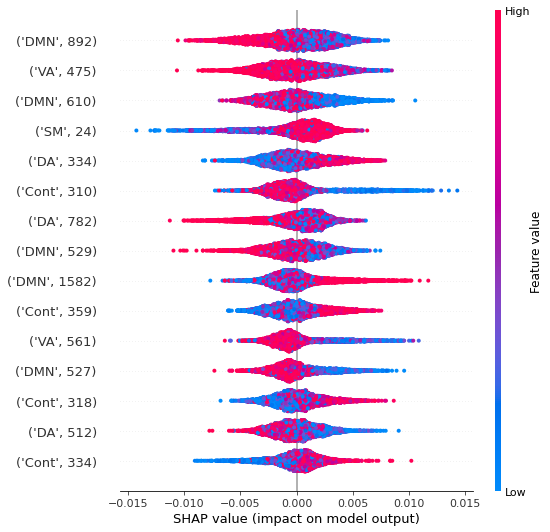

<Figure size 432x288 with 0 Axes>

In [26]:
shap.summary_plot(shap_values_MWDis[1], X,  max_display = 15)
plt.savefig("shap_MWvsALL_beeswarm.png") 

[Text(205.09383309202713, 214.24235294117648, "('Lm', 266) <= 0.971\ngini = 0.486\nsamples = 5616\nvalue = [3680, 5180]\nclass = ALL"),
 Text(97.11528172323709, 207.8470588235294, "('VA', 610) <= -0.695\ngini = 0.49\nsamples = 4778\nvalue = [3259, 4316]\nclass = ALL"),
 Text(39.970066979236435, 201.45176470588234, "('Lm', 257) <= 0.053\ngini = 0.5\nsamples = 1031\nvalue = [855, 811]\nclass = MW"),
 Text(18.182652377762896, 195.0564705882353, "('DMN', 1065) <= 0.278\ngini = 0.487\nsamples = 512\nvalue = [343, 472]\nclass = ALL"),
 Text(6.996490288010717, 188.66117647058823, "('DMN', 344) <= 0.577\ngini = 0.348\nsamples = 164\nvalue = [59, 204]\nclass = ALL"),
 Text(3.9467381111855326, 182.26588235294116, "('DMN', 1361) <= -0.426\ngini = 0.462\nsamples = 88\nvalue = [47, 83]\nclass = ALL"),
 Text(2.3919624916275954, 175.87058823529412, "('DMN', 968) <= 0.687\ngini = 0.185\nsamples = 39\nvalue = [6, 52]\nclass = ALL"),
 Text(1.9135699933020764, 169.47529411764705, "('SM', 10) <= 0.905\ngi

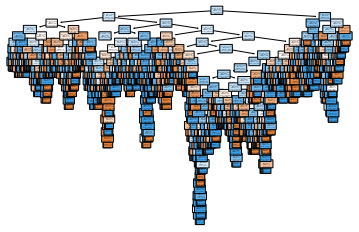

In [27]:
from sklearn.tree import plot_tree
plot_tree(model.estimators_[0], 
          feature_names=X.columns,
          class_names=['MW', 'ALL'], 
          filled=True, impurity=True, 
          rounded=True)

In [ ]:
expected_value = explainer.expected_value
shap.decision_plot(expected_value[1], shap_values[1],feature_names=list(X.columns), ignore_warnings = True)

RuntimeError: Plotting 8860 observations may be slow. Consider subsampling or set ignore_warnings=True to ignore this message.

In [30]:
from sklearn.metrics import RocCurveDisplay

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.


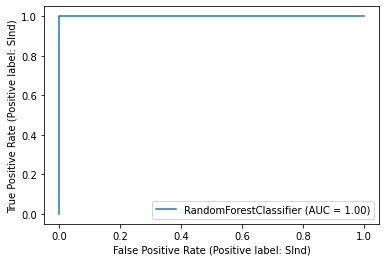

In [32]:
RocCurveDisplay.from_estimator(
...    model_MWDis, X, y)